In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from HS_reading import *
from tqdm import trange
from copy import deepcopy

# 个人设置

In [2]:
# clean_data_path = "/Users/zhaozehao/Desktop/reading task"
# clear_path = "/Users/zhaozehao/Desktop/reading task/"

clean_data_path = "D:/BaiduSyncdisk/code"
clear_path = "D:/BaiduSyncdisk/code/"
HS_list = [44, 45, 47, 48, 50, 54, 71, 73, 76,78]

# onset latency是显著电极的第一个显著的时间

In [3]:
def p_value_calculate(ecogReading_task):
    start = 150 - 25
    end = start+5

    b = ecogReading_task[start:end,].reshape(1,-1) #取-250ms ~ -200ms 的时间窗作为基线
    p_value = np.zeros([ecogReading_task.shape[0]])
    for t in range(ecogReading_task.shape[0]):
         #每个时间点完成一次t检验
        d = ecogReading_task[t,:].reshape(1,-1) #每个时间点完成一次t检验
        p_value[t] = stats.ttest_ind(b[:, ~np.isnan(b).any(axis=0)].T,
                                d[:, ~np.isnan(d).any(axis=0)].T,
                                alternative='less').pvalue #两独立样本t检验
    return p_value
        
        

In [3]:
HS_list = [44, 45, 47, 48, 50,54, 71,73,76,78]

test = classification(HS_list,clear_path)
print(test)
for i in test:
    print(i,len(test[i]))

{'44': {'postcentral': [0, 1, 2, 3, 4, 5, 6, 7, 16, 17, 18, 19, 20, 21, 22, 32, 33, 34, 35, 49, 50, 71, 72, 73, 74, 75, 76, 86, 87, 88, 89, 90, 91, 92, 102, 103, 104, 105, 106, 107, 119, 120], 'precentral': [8, 9, 10, 11, 23, 24, 25, 36, 37, 38, 39, 40, 51, 52, 53, 54, 55, 56, 77, 78, 79, 95, 108, 121, 122, 123], 'middlefrontal': [12, 13, 14, 15, 26, 27, 28, 29, 30, 31, 41, 42, 43, 44, 45, 46, 47, 57, 58, 59, 60, 61, 62, 63, 93, 94, 109, 110, 111, 124, 125, 126, 127], 'superiortemporal': [48, 112], 'supramarginal': [64, 65, 66, 67, 68, 69, 70, 80, 81, 82, 83, 84, 85, 96, 97, 98, 99, 100, 101, 113, 114, 115, 116, 117, 118]}, '45': {'supramarginal': [0, 1, 2, 3, 4, 5, 16, 17, 18, 19, 20, 21, 34, 64, 65, 66, 67, 68, 69, 70, 80, 81, 82, 83, 84, 85, 86, 87, 96, 97, 98, 99, 100, 101, 102, 103, 112, 113, 114, 115, 116, 117, 118], 'postcentral': [6, 7, 8, 9, 10, 11, 22, 23, 24, 25, 32, 33, 35, 36, 37, 38, 39, 40, 48, 49, 50, 51, 52, 53, 71, 72, 73, 74, 75, 76, 77, 78, 79, 88, 89, 90, 91, 92, 9

In [5]:
def replace_region(xy):
    old_region = xy[:,3]
    for i in range(len(old_region)):
        if old_region[i][0] in "bankssts":
            old_region[i][0] = "middletemporal"
            print(old_region[i][0])
        elif "middlefrontal" in old_region[i][0]:
            old_region[i][0] = "middlefrontal"
            print(old_region[i][0])
    xy[:,3] = old_region
    return xy
            
def lag_data_generate(HS_list, clean_data_path):
    place_list = []
    avgECoG = {}
    sound_list1 = ["ba", "bu", "da", "du", "ga", "gu"]
    task_name_list1 = ["overt", "covert"]
    sound_list2 = ["ba", "da", "ga", "pa", "ta", "ka", "sa", "sha"]
    task_name_list2 = ["overt", "covert", "cue"]
    for task in task_name_list2:
        avgECoG[task] = {}
    for HS in HS_list:
        # xycolor = scio.loadmat(clean_data_path + "/elecs/warped/HS" + str(HS) + "_elecs_all_warped.mat")["anatomy"]
        # elec_sig = np.load(clean_data_path+"/elecs/elec_sig/" + str(HS) + "sig_elecs.npy",allow_pickle=True).item()

        xycolor = test[str(HS)]
        
        elec_sig = np.load(clean_data_path + "/elecs/elec_sig/" + str(HS) + "sig_elecs.npy", allow_pickle=True).item()

        place_list.extend(np.unique(list(xycolor.keys())))

        for task in task_name_list2:
            for i in range(len(place_list)):
                if place_list[i] not in avgECoG[task].keys():
                    avgECoG[task][place_list[i]] = []

        clean_data_path_block = os.path.join(clean_data_path, "HSblockdata")
        file_name = "HS" + str(HS) + "_Block_overt_covert.mat"
        HSblock = scio.loadmat(os.path.join(clean_data_path_block, file_name))
        HSblock = HSblock["Alldata"][0][0]
        n_chans = 128 if HS==44 else 256
        # 为各个place各个task增加一行对特定音节该电极上的平均
        task_name_list = task_name_list2 if HS>54 else task_name_list1
        sound_list = sound_list2 if HS>54 else sound_list1
        for task in task_name_list:

            for i in trange(n_chans,desc=f'HS{HS}'):
                for region in list(xycolor.keys()):
                    if i in xycolor[region]:
                        if i in elec_sig[task]:
                            elec_ecog = []
                            for sound in sound_list:
                                elec_ecog.append(np.mean(HSblock["ECoG_"+task+"_"+sound][:, i, :],axis=0))
                            avgECoG[task][region].append(elec_ecog)
                    
    place_list = np.unique(place_list)
        
    for task in task_name_list:
        for region in place_list:
            print(region,len(avgECoG[task][region]))
    return place_list, avgECoG

In [6]:
def lag_sig_data_generate(HS_list, clean_data_path):
    place_list = []
    avgECoG = {}
    sound_list1 = ["ba", "bu", "da", "du", "ga", "gu"]
    task_name_list1 = ["overt", "covert"]
    sound_list2 = ["ba", "da", "ga", "pa", "ta", "ka", "sa", "sha"]
    task_name_list2 = ["overt", "covert", "cue"]
    for task in task_name_list2:
        avgECoG[task] = {}
    for HS in HS_list:
        # xycolor = scio.loadmat(clean_data_path + "/elecs/warped/HS" + str(HS) + "_elecs_all_warped.mat")["anatomy"]
        # elec_sig = np.load(clean_data_path+"/elecs/elec_sig/" + str(HS) + "sig_elecs.npy",allow_pickle=True).item()

        xycolor = test[str(HS)]
        
        elec_sig = np.load(clean_data_path + "/elecs/elec_sig/" + str(HS) + "sig_elecs.npy", allow_pickle=True).item()

        place_list.extend(np.unique(list(xycolor.keys())))

        for task in task_name_list2:
            for i in range(len(place_list)):
                if place_list[i] not in avgECoG[task].keys():
                    avgECoG[task][place_list[i]] = []

        clean_data_path_block = os.path.join(clean_data_path, "HSblockdata")
        file_name = "HS" + str(HS) + "_Block_overt_covert.mat"
        HSblock = scio.loadmat(os.path.join(clean_data_path_block, file_name))
        HSblock = HSblock["Alldata"][0][0]
        n_chans = 128 if HS==44 else 256
        # 为各个place各个task增加一行对特定音节该电极上的平均
        task_name_list = task_name_list2 if HS>54 else task_name_list1
        sound_list = sound_list2 if HS>54 else sound_list1
        for task in task_name_list:

            for i in trange(n_chans,desc=f'HS{HS}'):
                for region in list(xycolor.keys()):
                    if i in xycolor[region]:
                        if i in elec_sig[task]:
                            elec_ecog = []
                            for sound in sound_list:
                                elec_ecog.append(p_value_calculate(HSblock["ECoG_"+task+"_"+sound][:, i, :].T))
                            avgECoG[task][region].append(elec_ecog)
            
            
    place_list = np.unique(place_list)
        
    for task in task_name_list:
        for region in place_list:
            print(region,len(avgECoG[task][region]))
                            
  
    return place_list, avgECoG

In [7]:
def lag_elec_data_generate(HS_list, clean_data_path):
    place_list = []
    avgECoG = {}
    sound_list1 = ["ba", "bu", "da", "du", "ga", "gu"]
    task_name_list1 = ["overt", "covert"]
    sound_list2 = ["ba", "da", "ga", "pa", "ta", "ka", "sa", "sha"]
    task_name_list2 = ["overt", "covert", "cue"]
    for task in task_name_list2:
        avgECoG[task] = {}
    for HS in HS_list:
        # xycolor = scio.loadmat(clean_data_path + "/elecs/warped/HS" + str(HS) + "_elecs_all_warped.mat")["anatomy"]
        # elec_sig = np.load(clean_data_path+"/elecs/elec_sig/" + str(HS) + "sig_elecs.npy",allow_pickle=True).item()

        xycolor = test[str(HS)]
        
        elec_sig = np.load(clean_data_path + "/elecs/elec_sig/" + str(HS) + "sig_elecs.npy", allow_pickle=True).item()

        place_list.extend(np.unique(list(xycolor.keys())))

        for task in task_name_list2:
            for i in range(len(place_list)):
                if place_list[i] not in avgECoG[task].keys():
                    avgECoG[task][place_list[i]] = []

        n_chans = 128 if HS==44 else 256
        # 为各个place各个task增加一行对特定音节该电极上的平均
        task_name_list = task_name_list2 if HS>54 else task_name_list1
        sound_list = sound_list2 if HS>54 else sound_list1
        for task in task_name_list:

            for i in range(n_chans):
                for region in list(xycolor.keys()):
                    if i in xycolor[region]:
                        if i in elec_sig[task]:
                            avgECoG[task][region].append(f'HS{HS}_{i}')
            
            
    place_list = np.unique(place_list)
        
    for task in task_name_list:
        for region in place_list:
            print(region,len(avgECoG[task][region]))
                            
  
    return place_list, avgECoG

In [8]:
def find_continus(aa):
    l1 = []
    total = []
    for x in sorted(set(aa)):
        l1.append(x)
        if x + 1 not in aa:
            total.append(l1)
            l1 = []
    return total


def get_max_len(aa):
    max_len = 1
    start_value = np.NaN
    end_value = np.NaN
    flag = 0
    for a in aa:
        if len(a) >= max_len:
            if flag == 0:
                start_value = a[0]
                flag += 1
            end_value = a[-1]

    return [max_len, start_value, end_value]

# 对latency onset 的数据处理

In [9]:
# place_list,sig_avgECoG = lag_sig_data_generate(HS_list,clean_data_path)


In [10]:
# np.save(clean_data_path+"/sig_data_true_figure.npy",sig_avgECoG)

In [11]:
sig_avgECoG = np.load(clean_data_path+"/sig_data_true_figure.npy",allow_pickle=True).item()
task_list = ["overt","covert","cue"]
alpha = 0.05
onset_time_dict_p = {}
end_time_dict_p = {}
for task in task_list:
    start_time = 150 if task == "cue" else 130
    end_time = start_time+170
    onset_time_dict_p[task] = {}
    end_time_dict_p[task] = {}
    for region in list(sig_avgECoG[task].keys()):
        onset_time_dict_p[task][region] = {}
        end_time_dict_p[task][region] = {}
        print(region,len(sig_avgECoG[task][region]))
        for elec in range(len(sig_avgECoG[task][region])):
            onset_time_dict_p[task][region][elec] = []
            end_time_dict_p[task][region][elec] = []
            
            #print(len(avgECoG['overt']['postcentral'][i]))
            for sound in range(len(sig_avgECoG[task][region][elec])):
                #对指定范围内的p值进行鉴定
                p_value_seq =  np.ones_like(sig_avgECoG[task][region][elec][sound])
                p_value_seq[start_time:end_time] = sig_avgECoG[task][region][elec][sound][start_time:end_time]
                seg_index = np.where(p_value_seq < alpha)[0]
                if len(seg_index) >0:
                    onset_time_dict_p[task][region][elec].append(get_max_len(find_continus(seg_index))[1])
                    end_time_dict_p[task][region][elec].append(get_max_len(find_continus(seg_index))[2])
                else:
                    onset_time_dict_p[task][region][elec].append(np.NaN)
                    end_time_dict_p[task][region][elec].append(np.NaN)
    #for j in range(len(avgECoG['overt']['postcentral'][i])):
       #print(len(avgECoG['overt']['postcentral'][i][j]))

middlefrontal 124
postcentral 254
precentral 235
superiortemporal 66
supramarginal 221
parsopercularis 36
superiorfrontal 4
middletemporal 40
parstriangularis 17
inferiorparietal 32
parsorbitalis 0
inferiortemporal 4
lateraloccipital 8
superiorparietal 27
middlefrontal 81
postcentral 201
precentral 173
superiortemporal 59
supramarginal 144
parsopercularis 20
superiorfrontal 1
middletemporal 35
parstriangularis 13
inferiorparietal 19
parsorbitalis 0
inferiortemporal 7
lateraloccipital 8
superiorparietal 15
middlefrontal 41
postcentral 70
precentral 66
superiortemporal 46
supramarginal 81
parsopercularis 16
superiorfrontal 2
middletemporal 15
parstriangularis 15
inferiorparietal 0
parsorbitalis 0
inferiortemporal 2
lateraloccipital 0
superiorparietal 4


In [12]:
onset_time_dict = {}
end_time_dict = {}
for task in task_list:
    onset_time_dict[task] = {}
    end_time_dict[task] = {}
    for region in list(sig_avgECoG[task].keys()):
        onset_time_dict[task][region] = []
        end_time_dict[task][region] = []
        for elec in range(len(sig_avgECoG[task][region])):
            onset_time_dict[task][region].append(np.floor(np.nanmean(onset_time_dict_p[task][region][elec])))
            end_time_dict[task][region].append(np.floor(np.nanmean(end_time_dict_p[task][region][elec])))
        print(region,len(onset_time_dict[task][region]))
        

middlefrontal 124
postcentral 254
precentral 235
superiortemporal 66
supramarginal 221
parsopercularis 36
superiorfrontal 4
middletemporal 40
parstriangularis 17
inferiorparietal 32
parsorbitalis 0
inferiortemporal 4
lateraloccipital 8
superiorparietal 27
middlefrontal 81
postcentral 201
precentral 173
superiortemporal 59
supramarginal 144
parsopercularis 20
superiorfrontal 1
middletemporal 35
parstriangularis 13
inferiorparietal 19
parsorbitalis 0
inferiortemporal 7
lateraloccipital 8
superiorparietal 15
middlefrontal 41
postcentral 70
precentral 66
superiortemporal 46
supramarginal 81
parsopercularis 16
superiorfrontal 2
middletemporal 15
parstriangularis 15
inferiorparietal 0
parsorbitalis 0
inferiortemporal 2
lateraloccipital 0
superiorparietal 4


# 对latency peak 的数据处理

In [13]:
place_list, avgECoG = lag_data_generate(HS_list, clean_data_path)

HS78: 100%|██████████| 256/256 [00:00<00:00, 3600.36it/s]

inferiorparietal 32
inferiortemporal 4
lateraloccipital 8
middlefrontal 124
middletemporal 40
parsopercularis 36
parsorbitalis 0
parstriangularis 17
postcentral 254
precentral 235
superiorfrontal 4
superiorparietal 27
superiortemporal 66
supramarginal 221
inferiorparietal 19
inferiortemporal 7
lateraloccipital 8
middlefrontal 81
middletemporal 35
parsopercularis 20
parsorbitalis 0
parstriangularis 13
postcentral 201
precentral 173
superiorfrontal 1
superiorparietal 15
superiortemporal 59
supramarginal 144
inferiorparietal 0
inferiortemporal 2
lateraloccipital 0
middlefrontal 41
middletemporal 15
parsopercularis 16
parsorbitalis 0
parstriangularis 15
postcentral 70
precentral 66
superiorfrontal 2
superiorparietal 4
superiortemporal 46
supramarginal 81


In [14]:
gauss = False
sound_list2 = ["ba", "da", "ga", "pa", "ta", "ka", "sa", "sha"]
task_name_list2 = ["overt", "covert", "cue"]
elec_avg_ECoG = {}
for task in task_name_list2:
    elec_avg_ECoG[task] = {}
    for region in list(avgECoG[task].keys()):
        elec_avg_ECoG[task][region] = []
        for elec in range(len(avgECoG[task][region])):
            temp = deepcopy(avgECoG[task][region][elec])
            elec_avg_ECoG[task][region].append(np.mean(np.array(temp),axis=0))
        print(region,len(avgECoG[task][region]))
        #print(np.size(np.array(temp)))
        #avgECoG[task][place_list[i]] = np.mean(np.array(avgECoG[task][place_list[i]]),axis=0)
        #if avgECoG[task][place_list[i]].shape[0] == 1:
        #    avgECoG[task][place_list[i]] = np.expand_dims(avgECoG[task][place_list[i]],0)

middlefrontal 124
postcentral 254
precentral 235
superiortemporal 66
supramarginal 221
parsopercularis 36
superiorfrontal 4
middletemporal 40
parstriangularis 17
inferiorparietal 32
parsorbitalis 0
inferiortemporal 4
lateraloccipital 8
superiorparietal 27
middlefrontal 81
postcentral 201
precentral 173
superiortemporal 59
supramarginal 144
parsopercularis 20
superiorfrontal 1
middletemporal 35
parstriangularis 13
inferiorparietal 19
parsorbitalis 0
inferiortemporal 7
lateraloccipital 8
superiorparietal 15
middlefrontal 41
postcentral 70
precentral 66
superiortemporal 46
supramarginal 81
parsopercularis 16
superiorfrontal 2
middletemporal 15
parstriangularis 15
inferiorparietal 0
parsorbitalis 0
inferiortemporal 2
lateraloccipital 0
superiorparietal 4


# 生成各个脑区各个电极的标签, 生成C-CO-O

In [15]:
_,elec_label_avg_ECoG = lag_elec_data_generate(HS_list,clean_data_path)
for task in task_list:
    for region in place_list:
        print(elec_label_avg_ECoG[task][region])

inferiorparietal 32
inferiortemporal 4
lateraloccipital 8
middlefrontal 124
middletemporal 40
parsopercularis 36
parsorbitalis 0
parstriangularis 17
postcentral 254
precentral 235
superiorfrontal 4
superiorparietal 27
superiortemporal 66
supramarginal 221
inferiorparietal 19
inferiortemporal 7
lateraloccipital 8
middlefrontal 81
middletemporal 35
parsopercularis 20
parsorbitalis 0
parstriangularis 13
postcentral 201
precentral 173
superiorfrontal 1
superiorparietal 15
superiortemporal 59
supramarginal 144
inferiorparietal 0
inferiortemporal 2
lateraloccipital 0
middlefrontal 41
middletemporal 15
parsopercularis 16
parsorbitalis 0
parstriangularis 15
postcentral 70
precentral 66
superiorfrontal 2
superiorparietal 4
superiortemporal 46
supramarginal 81
['HS48_0', 'HS48_1', 'HS54_133', 'HS54_134', 'HS54_135', 'HS54_136', 'HS54_137', 'HS54_147', 'HS54_150', 'HS54_162', 'HS54_163', 'HS54_167', 'HS54_178', 'HS54_179', 'HS54_187', 'HS54_188', 'HS54_195', 'HS54_203', 'HS54_204', 'HS54_211', 'H

In [16]:
def get_venne_time(exclude_task,region_list):
    task_venne_list = [ i for i in ["overt","covert","cue"] if i != exclude_task ]
    set_A = {}
    set_B = {}
    set_AB = {}
    set_BA = {}
    peak = {}
    for task in task_venne_list:
        data_counts = []
        filtered_place_list = region_list
        print(task,filtered_place_list)
        onset = onset_time_dict[task]
        offset = end_time_dict[task]
        peak[task] = {}
        for i in range(len(filtered_place_list)):
            temp = elec_avg_ECoG[task][filtered_place_list[i]]

            data_counts.append(len(temp))
            # temp[temp<0]=0
            peak[task][filtered_place_list[i]] = np.zeros(len(temp)).astype(np.float64)
            for j in range(len(temp)):
                if np.isnan(onset[filtered_place_list[i]][j])or np.isnan(offset[filtered_place_list[i]][j]):
                    peak[task][filtered_place_list[i]][j] = np.NaN
                else:
                    peak[task][filtered_place_list[i]][j] = int(np.argmax(temp[j][int(onset[filtered_place_list[i]][j]):int(offset[filtered_place_list[i]][j])])+onset[filtered_place_list[i]][j])

    task_A = task_venne_list[0]
    task_B = task_venne_list[1]
    #初始化
    for region in filtered_place_list:
        set_A[region] = {}
        set_B[region] = {}
        set_AB[region] = {}
        set_BA[region] = {}
        for name in ["onset","peak","offset"]:
            set_A[region][name] = []
            set_B[region][name] = []
            set_AB[region][name] = []
            set_BA[region][name] = []
    #赋值
    for region in filtered_place_list:
        
        for i in range(len(elec_label_avg_ECoG[task_A][region])):
            if elec_label_avg_ECoG[task_A][region][i] in elec_label_avg_ECoG[task_B][region]:
                set_AB[region]["peak"].append(peak[task_A][region][i])
                set_AB[region]["onset"].append(onset_time_dict[task_A][region][i])
                set_AB[region]["offset"].append(end_time_dict[task_A][region][i])
            if elec_label_avg_ECoG[task_A][region][i] not in elec_label_avg_ECoG[task_B][region]:
                set_A[region]["peak"].append(peak[task_A][region][i])
                set_A[region]["onset"].append(onset_time_dict[task_A][region][i])
                set_A[region]["offset"].append(end_time_dict[task_A][region][i])
                
        for i in range(len(elec_label_avg_ECoG[task_B][region])):
            if elec_label_avg_ECoG[task_B][region][i] in elec_label_avg_ECoG[task_A][region]:
                set_BA[region]["peak"].append(peak[task_B][region][i])
                set_BA[region]["onset"].append(onset_time_dict[task_B][region][i])
                set_BA[region]["offset"].append(end_time_dict[task_B][region][i])
            if elec_label_avg_ECoG[task_B][region][i] not in elec_label_avg_ECoG[task_A][region]:
                set_B[region]["peak"].append(peak[task_B][region][i])
                set_B[region]["onset"].append(onset_time_dict[task_B][region][i])
                set_B[region]["offset"].append(end_time_dict[task_B][region][i])
        print(region,len(set_A[region]["peak"]),len(set_B[region]["peak"]),len(set_AB[region]["peak"]),len(set_BA[region]["peak"]))
    return set_A,set_B,set_AB,set_BA   

In [17]:


# for i in range(len(elec_label_avg_ECoG["overt"]["postcentral"])):
#     if elec_label_avg_ECoG["overt"]["postcentral"][i] in elec_label_avg_ECoG["covert"]["postcentral"]:
#         print(elec_label_avg_ECoG["overt"]["postcentral"][i])
#         print(onset_time_dict["overt"]["postcentral"][i])
#         print(onset_time_dict["covert"]["postcentral"][elec_label_avg_ECoG["covert"]["postcentral"].index(elec_label_avg_ECoG["overt"]["postcentral"][i])])
# 


In [18]:
watch_region_list = ['parstriangularis', 'parsopercularis', 'middlefrontal',
                     'postcentral','precentral',
                     'supramarginal', 'inferiorparietal',
                     'superiortemporal', 'middletemporal']
set_A,set_B,set_AB,set_BA = get_venne_time("cue",watch_region_list)
print(len(watch_region_list))

overt ['parstriangularis', 'parsopercularis', 'middlefrontal', 'postcentral', 'precentral', 'supramarginal', 'inferiorparietal', 'superiortemporal', 'middletemporal']
covert ['parstriangularis', 'parsopercularis', 'middlefrontal', 'postcentral', 'precentral', 'supramarginal', 'inferiorparietal', 'superiortemporal', 'middletemporal']
parstriangularis 13 9 4 4
parsopercularis 25 9 11 11
middlefrontal 78 35 46 46
postcentral 88 35 166 166
precentral 90 28 145 145
supramarginal 121 44 100 100
inferiorparietal 23 10 9 9
superiortemporal 42 35 24 24
middletemporal 16 11 24 24
9


In [19]:
set_A

{'parstriangularis': {'onset': [180.0,
   227.0,
   159.0,
   168.0,
   165.0,
   162.0,
   172.0,
   180.0,
   190.0,
   186.0,
   219.0,
   162.0,
   153.0],
  'peak': [186.0,
   279.0,
   240.0,
   224.0,
   207.0,
   203.0,
   202.0,
   240.0,
   232.0,
   231.0,
   240.0,
   232.0,
   153.0],
  'offset': [224.0,
   286.0,
   264.0,
   291.0,
   279.0,
   284.0,
   282.0,
   274.0,
   235.0,
   236.0,
   251.0,
   233.0,
   209.0]},
 'parsopercularis': {'onset': [159.0,
   147.0,
   172.0,
   247.0,
   199.0,
   201.0,
   185.0,
   171.0,
   218.0,
   172.0,
   170.0,
   196.0,
   173.0,
   175.0,
   177.0,
   179.0,
   162.0,
   160.0,
   153.0,
   214.0,
   142.0,
   161.0,
   178.0,
   173.0,
   141.0],
  'peak': [163.0,
   166.0,
   195.0,
   251.0,
   261.0,
   234.0,
   208.0,
   201.0,
   218.0,
   209.0,
   189.0,
   285.0,
   209.0,
   224.0,
   224.0,
   202.0,
   166.0,
   160.0,
   173.0,
   230.0,
   171.0,
   171.0,
   229.0,
   224.0,
   141.0],
  'offset': [244.0,
 

In [20]:
labels = ['overt','covert','C-O overt','C-O covert']


# 列名列表
column_names = ['onset', 'peak', 'offset','task','region']

# 创建一个空的 DataFrame，仅包含列名
df_a = pd.DataFrame(columns=column_names)


for i in range(len(watch_region_list)):
    for j in range(len(labels)):
        if j == 0:   
            df_b = (pd.DataFrame(set_A[watch_region_list[i]])-150)/100
            df_b['task'] = labels[j]
            df_b['region'] = watch_region_list[i]
            df_a = pd.concat([df_a, df_b], axis=0)

        elif j == 1:
            df_b = (pd.DataFrame(set_B[watch_region_list[i]])-150)/100
            df_b['task'] = labels[j]
            df_b['region'] = watch_region_list[i]
            # 使用 concat 进行纵向合并
            df_a = pd.concat([df_a, df_b], axis=0)
        elif j == 2:
            df_b = (pd.DataFrame(set_AB[watch_region_list[i]])-150)/100
            df_b['task'] = labels[j]
            df_b['region'] = watch_region_list[i]
            # 使用 concat 进行纵向合并
            df_a = pd.concat([df_a, df_b], axis=0)
        elif j == 3:
            df_b = (pd.DataFrame(set_BA[watch_region_list[i]])-150)/100
            df_b['task'] = labels[j]
            df_b['region'] = watch_region_list[i]
            # 使用 concat 进行纵向合并
            df_a = pd.concat([df_a, df_b], axis=0)
df = df_a
df

,onset,peak,offset,task,region
0,0.30,0.36,0.74,overt,parstriangularis
1,0.77,1.29,1.36,overt,parstriangularis
2,0.09,0.90,1.14,overt,parstriangularis
3,0.18,0.74,1.41,overt,parstriangularis
4,0.15,0.57,1.29,overt,parstriangularis
...,...,...,...,...,...
19,0.36,0.57,0.91,C-O covert,middletemporal
20,0.22,0.67,1.01,C-O covert,middletemporal
21,0.34,1.00,1.21,C-O covert,middletemporal
22,0.48,0.78,1.16,C-O covert,middletemporal


In [21]:
import pandas as pd
from scipy.stats import f_oneway
def time_point_by_task(test_list, time_point):
    # 提取满足条件的行
    filtered_df = df[df['task'].isin(test_list)]
    # 提取对应的 onset 列的值并输出为一个数组
    onset_array = np.array(filtered_df[time_point])
#     print(onset_array)
    return(filtered_df)

def time_point_by_region(region_list, time_point):
    # 提取满足条件的行
    filtered_df = df[df['region'].isin(region_list)]
    # 提取对应的 onset 列的值并输出为一个数组
    onset_array = np.array(filtered_df[time_point])
#     print(onset_array)
    return(filtered_df)

color_set = {'superiorfrontal': 'grey', 
         'superiortemporal':'purple', 
         'inferiorparietal':'skyblue', 
         'rostralmiddlefrontal':'black', 
         'parstriangularis':'darkgreen', 
         'superiorparietal':'orange', 
         'postcentral':'blue', 
         'parsopercularis':'gold', 
         'middletemporal':'greenyellow', 
         'inferiortemporal':'pink', 
         'parsorbitalis':'olive', 
         'supramarginal':'green', 
         'lateraloccipital':'navy', 
         'bankssts':'rosybrown', 
         'precentral':'red', 
         'caudalmiddlefrontal':'slategrey',
             'middlefrontal':'grey' 
            }

In [22]:
import pandas as pd
from scipy.stats import f_oneway, ttest_ind
from statsmodels.stats.multitest import multipletests

time_point = "onset"

for i in watch_region_list:
    region_list = [i]
    print("\n\n"+i)
#     region_list = ['precentral','postcentral']
    
    labels = ['overt','covert','C-O overt','C-O covert']

    fil_df = time_point_by_region(region_list, time_point)

    # 根据 "task" 列分组，计算中位数和四分位数
    grouped = fil_df.groupby('task')[time_point]
    median_values = grouped.median()
    quantiles = grouped.quantile([0.25, 0.5, 0.75])

    # One-way ANOVA
    f_statistic, p_value = f_oneway(grouped.get_group(labels[0]), 
                                    grouped.get_group(labels[1]), 
                                    grouped.get_group(labels[2]), 
                                    grouped.get_group(labels[3]))

    # 打印 One-way ANOVA 结果
    print("One-way ANOVA results:")
    print(f"F-statistic: {f_statistic}")
    print(f"P-value: {p_value}")
    
    if p_value < 0.05:
        # 两两之间的 t 检验
        tasks = labels
        t_test_results = {}

        for i in range(len(tasks)):
            for j in range(i+1, len(tasks)):
                task1 = tasks[i]
                task2 = tasks[j]
                t_statistic, t_p_value = ttest_ind(grouped.get_group(task1), grouped.get_group(task2))
                t_test_results[f'{task1} vs {task2}'] = t_p_value


        # 多重比较校正
        alpha = 0.05
        reject, p_corrected, _, _ = multipletests(list(t_test_results.values()), method='bonferroni')
        # 打印多重比较校正后的阈值
        print("\nCorrected alpha (Bonferroni method):", alpha / len(p_corrected))

        # # 多重比较校正 (False Discovery Rate)
        # alpha = 0.05
        # reject, p_corrected, _, _ = multipletests(list(t_test_results.values()), method='fdr_bh')
        # # 打印多重比较校正后的阈值
        # print("\nCorrected alpha (FDR method):", alpha / len(p_corrected))


        # 打印两两之间的 t 检验的 p 值
        print("\nPairwise t-test results:")
        for comparison, p_value in t_test_results.items():
#             if p_value < alpha / len(p_corrected):
#                 print(f"{comparison}: p-value = {p_value}")
                
            if p_value < alpha:
                print(f"{comparison}: p-value = {p_value}")
                
        # # 打印中位数和四分位数
        # print("\nMedian values:")
        # print(median_values)
        # print("\nQuantiles:")
        # print(quantiles)



parstriangularis
One-way ANOVA results:
F-statistic: 0.22927851908160204
P-value: 0.8751505567484184


parsopercularis
One-way ANOVA results:
F-statistic: 1.3815788086522443
P-value: 0.2587093281695002


middlefrontal
One-way ANOVA results:
F-statistic: 5.278319692418694
P-value: 0.0015925376845557096

Corrected alpha (Bonferroni method): 0.008333333333333333

Pairwise t-test results:
overt vs covert: p-value = 0.008772955528715199
overt vs C-O covert: p-value = 0.0013388465406437705
covert vs C-O overt: p-value = 0.0389755058862687
C-O overt vs C-O covert: p-value = 0.010355179933281647


postcentral
One-way ANOVA results:
F-statistic: 2.7444952193817302
P-value: 0.04265938105054436

Corrected alpha (Bonferroni method): 0.008333333333333333

Pairwise t-test results:
overt vs covert: p-value = 0.019284430945128484
overt vs C-O covert: p-value = 0.03663759229455757


precentral
One-way ANOVA results:
F-statistic: 0.8892901889869913
P-value: 0.44665727335985994


supramarginal
One-way 

In [23]:
import pandas as pd
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn

time_point = "onset"

for i in watch_region_list:
    region_list = [i]
    print("\n\n"+i)
#     region_list = ['precentral','postcentral']
    
    labels = ['overt','covert','C-O overt','C-O covert']

    fil_df = time_point_by_region(region_list, time_point)

    # 根据 "task" 列分组，获取每个组的数据
    grouped = [group[time_point].values for name, group in fil_df.groupby('task')]

    # 进行Kruskal-Wallis检验
    H_statistic, p_value = kruskal(*grouped)

    # 打印 Kruskal-Wallis 检验结果
    print("Kruskal-Wallis results:")
    print(f"H-statistic: {H_statistic}")
    print(f"P-value: {p_value}")
    
    # 如果Kruskal-Wallis检验显示了显著的差异
    if p_value < 0.05:
        # 进行Dunn's检验
        dunn_results = posthoc_dunn(fil_df, val_col=time_point, group_col='task', p_adjust='holm')

        # 打印Dunn's检验结果
        print("\nDunn's test results:")
        print(dunn_results)
        
        # 假设你想检查显著性水平为0.05
        alpha = 0.05

        # 获取所有p值小于alpha的比较
        significant_comparisons = dunn_results[dunn_results < alpha]

        # 打印显著性比较
        print("Significant Comparisons:")
        print(significant_comparisons)




parstriangularis
Kruskal-Wallis results:
H-statistic: 1.5649643034463863
P-value: 0.6673597572249098


parsopercularis
Kruskal-Wallis results:
H-statistic: 2.928983276905709
P-value: 0.4027046582570514


middlefrontal
Kruskal-Wallis results:
H-statistic: 13.913266849022904
P-value: 0.003025620320596318

Dunn's test results:
            C-O covert  C-O overt    covert     overt
C-O covert    1.000000   0.086161  1.000000  0.008470
C-O overt     0.086161   1.000000  0.189365  1.000000
covert        1.000000   0.189365  1.000000  0.045259
overt         0.008470   1.000000  0.045259  1.000000
Significant Comparisons:
            C-O covert  C-O overt    covert     overt
C-O covert         NaN        NaN       NaN  0.008470
C-O overt          NaN        NaN       NaN       NaN
covert             NaN        NaN       NaN  0.045259
overt          0.00847        NaN  0.045259       NaN


postcentral
Kruskal-Wallis results:
H-statistic: 9.140797243223696
P-value: 0.027476314627670275

Dunn's 

In [24]:
import pandas as pd
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn

time_point = "peak"

for i in watch_region_list:
    region_list = [i]
    print("\n\n"+i)
#     region_list = ['precentral','postcentral']
    
    labels = ['overt','covert','C-O overt','C-O covert']

    fil_df = time_point_by_region(region_list, time_point)

    # 根据 "task" 列分组，获取每个组的数据
    grouped = [group[time_point].values for name, group in fil_df.groupby('task')]

    # 进行Kruskal-Wallis检验
    H_statistic, p_value = kruskal(*grouped)

    # 打印 Kruskal-Wallis 检验结果
    print("Kruskal-Wallis results:")
    print(f"H-statistic: {H_statistic}")
    print(f"P-value: {p_value}")
    
    # 如果Kruskal-Wallis检验显示了显著的差异
    if p_value < 0.05:
        # 进行Dunn's检验
        dunn_results = posthoc_dunn(fil_df, val_col=time_point, group_col='task', p_adjust='holm')

        # 打印Dunn's检验结果
        print("\nDunn's test results:")
        print(dunn_results)
        
        # 假设你想检查显著性水平为0.05
        alpha = 0.05

        # 获取所有p值小于alpha的比较
        significant_comparisons = dunn_results[dunn_results < alpha]

        # 打印显著性比较
        print("Significant Comparisons:")
        print(significant_comparisons)




parstriangularis
Kruskal-Wallis results:
H-statistic: 4.421579717034256
P-value: 0.21939276854253179


parsopercularis
Kruskal-Wallis results:
H-statistic: 9.956528647288458
P-value: 0.01893929530861713

Dunn's test results:
            C-O covert  C-O overt    covert     overt
C-O covert    1.000000   0.416155  0.269348  0.495311
C-O overt     0.416155   1.000000  0.013380  0.136288
covert        0.269348   0.013380  1.000000  0.416155
overt         0.495311   0.136288  0.416155  1.000000
Significant Comparisons:
            C-O covert  C-O overt   covert  overt
C-O covert         NaN        NaN      NaN    NaN
C-O overt          NaN        NaN  0.01338    NaN
covert             NaN    0.01338      NaN    NaN
overt              NaN        NaN      NaN    NaN


middlefrontal
Kruskal-Wallis results:
H-statistic: 1.3882860923931866
P-value: 0.7082828191260143


postcentral
Kruskal-Wallis results:
H-statistic: 24.43964800814148
P-value: 2.0219690763249132e-05

Dunn's test results:
     

In [93]:
def plot_region(test_list, time_point):
    # 根据 "region" 列分组，计算中位数和四分位数
    fil_df = time_point_by_task(test_list, time_point)
    grouped = fil_df.groupby('region')[time_point]
    median_values = grouped.median()
    quantiles = grouped.quantile([0.25, 0.5, 0.75])

    plt.figure(figsize=(5, 5))  # 可选，设置图形大小
#     plt.figure()  # 可选，设置图形大小


    sns.set(style="whitegrid")  # 设置样式，可选
    # 绘制横向箱线图
    # sns.boxplot(y='region', x='onset', data=fil_df, order=median_values.sort_values().index,palette=color_set)
    sns.violinplot(x=time_point, y='region', data=fil_df, order=median_values.sort_values().index, 
                   palette=color_set,cut=0)


    # 设置标题和标签
    plt.title('Boxplot of '+time_point+' by Region')
    plt.xlabel('Latency (s)')
    plt.ylabel('Region')
    plt.xlim(-0.2, 1.5)

    # 显示图形
    plt.show()

    # 打印中位数和四分位数
    print("Median values:")
    print(median_values)
    print("\nQuantiles:")
    print(quantiles)

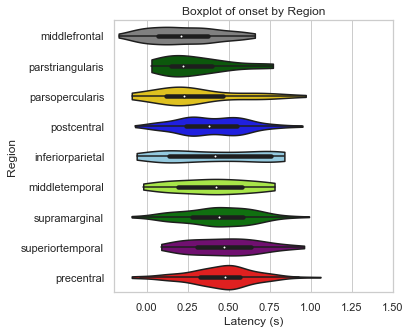

Median values:
region
inferiorparietal    0.420
middlefrontal       0.210
middletemporal      0.425
parsopercularis     0.230
parstriangularis    0.220
postcentral         0.380
precentral          0.480
superiortemporal    0.475
supramarginal       0.440
Name: onset, dtype: float64

Quantiles:
region                
inferiorparietal  0.25    0.1350
                  0.50    0.4200
                  0.75    0.7600
middlefrontal     0.25    0.0675
                  0.50    0.2100
                  0.75    0.3725
middletemporal    0.25    0.1900
                  0.50    0.4250
                  0.75    0.5825
parsopercularis   0.25    0.1200
                  0.50    0.2300
                  0.75    0.4675
parstriangularis  0.25    0.1500
                  0.50    0.2200
                  0.75    0.4000
postcentral       0.25    0.2400
                  0.50    0.3800
                  0.75    0.5500
precentral        0.25    0.3250
                  0.50    0.4800
                  0.7

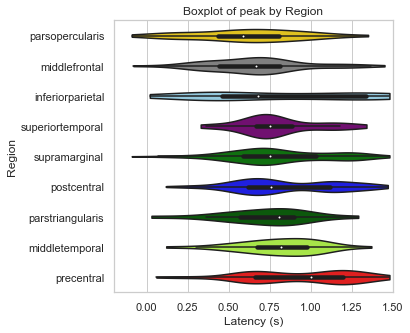

Median values:
region
inferiorparietal    0.68
middlefrontal       0.67
middletemporal      0.82
parsopercularis     0.59
parstriangularis    0.81
postcentral         0.76
precentral          1.00
superiortemporal    0.75
supramarginal       0.75
Name: peak, dtype: float64

Quantiles:
region                
inferiorparietal  0.25    0.4575
                  0.50    0.6800
                  0.75    1.3350
middlefrontal     0.25    0.4400
                  0.50    0.6700
                  0.75    0.8125
middletemporal    0.25    0.6725
                  0.50    0.8200
                  0.75    0.9750
parsopercularis   0.25    0.4350
                  0.50    0.5900
                  0.75    0.8100
parstriangularis  0.25    0.5700
                  0.50    0.8100
                  0.75    0.9000
postcentral       0.25    0.6200
                  0.50    0.7600
                  0.75    1.1200
precentral        0.25    0.6600
                  0.50    1.0000
                  0.75    1.200

In [96]:
test_list = ['overt','C-O overt']
time_list = ['onset','peak']

for time_point in time_list:
    plot_region(test_list, time_point)

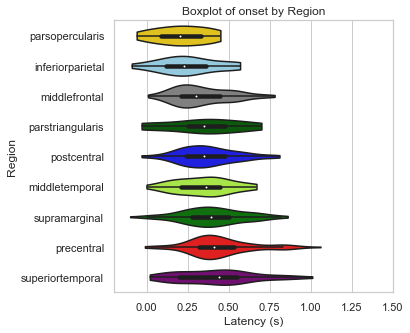

Median values:
region
inferiorparietal    0.230
middlefrontal       0.300
middletemporal      0.360
parsopercularis     0.205
parstriangularis    0.350
postcentral         0.350
precentral          0.410
superiortemporal    0.440
supramarginal       0.390
Name: onset, dtype: float64

Quantiles:
region                
inferiorparietal  0.25    0.1200
                  0.50    0.2300
                  0.75    0.3600
middlefrontal     0.25    0.2100
                  0.50    0.3000
                  0.75    0.4500
middletemporal    0.25    0.2100
                  0.50    0.3600
                  0.75    0.4450
parsopercularis   0.25    0.0900
                  0.50    0.2050
                  0.75    0.3325
parstriangularis  0.25    0.2500
                  0.50    0.3500
                  0.75    0.4800
postcentral       0.25    0.2400
                  0.50    0.3500
                  0.75    0.4800
precentral        0.25    0.3200
                  0.50    0.4100
                  0.7

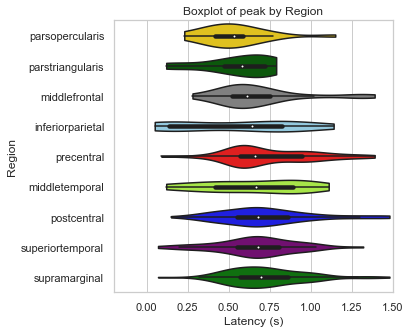

Median values:
region
inferiorparietal    0.64
middlefrontal       0.61
middletemporal      0.67
parsopercularis     0.53
parstriangularis    0.58
postcentral         0.68
precentral          0.66
superiortemporal    0.68
supramarginal       0.70
Name: peak, dtype: float64

Quantiles:
region                
inferiorparietal  0.25    0.1350
                  0.50    0.6400
                  0.75    0.8250
middlefrontal     0.25    0.5200
                  0.50    0.6100
                  0.75    0.7500
middletemporal    0.25    0.4150
                  0.50    0.6700
                  0.75    0.8900
parsopercularis   0.25    0.4150
                  0.50    0.5300
                  0.75    0.5875
parstriangularis  0.25    0.4700
                  0.50    0.5800
                  0.75    0.7200
postcentral       0.25    0.5500
                  0.50    0.6800
                  0.75    0.8600
precentral        0.25    0.5700
                  0.50    0.6600
                  0.75    0.950

In [97]:
test_list = ['covert','C-O covert']
time_list = ['onset','peak']

for time_point in time_list:
    plot_region(test_list, time_point)

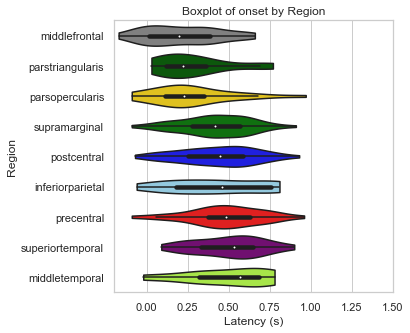

Median values:
region
inferiorparietal    0.460
middlefrontal       0.195
middletemporal      0.570
parsopercularis     0.230
parstriangularis    0.220
postcentral         0.450
precentral          0.485
superiortemporal    0.535
supramarginal       0.420
Name: onset, dtype: float64

Quantiles:
region                
inferiorparietal  0.25    0.1800
                  0.50    0.4600
                  0.75    0.7600
middlefrontal     0.25    0.0150
                  0.50    0.1950
                  0.75    0.3850
middletemporal    0.25    0.3200
                  0.50    0.5700
                  0.75    0.6825
parsopercularis   0.25    0.1100
                  0.50    0.2300
                  0.75    0.3500
parstriangularis  0.25    0.1200
                  0.50    0.2200
                  0.75    0.3600
postcentral       0.25    0.2550
                  0.50    0.4500
                  0.75    0.5900
precentral        0.25    0.3725
                  0.50    0.4850
                  0.7

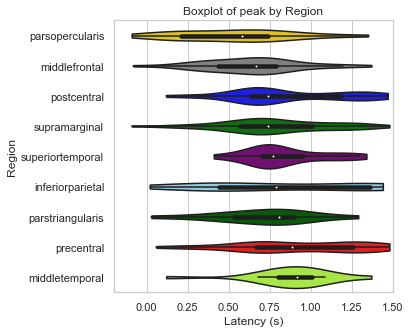

Median values:
region
inferiorparietal    0.790
middlefrontal       0.670
middletemporal      0.915
parsopercularis     0.580
parstriangularis    0.810
postcentral         0.740
precentral          0.885
superiortemporal    0.770
supramarginal       0.740
Name: peak, dtype: float64

Quantiles:
region                
inferiorparietal  0.25    0.4400
                  0.50    0.7900
                  0.75    1.3600
middlefrontal     0.25    0.4325
                  0.50    0.6700
                  0.75    0.7900
middletemporal    0.25    0.8025
                  0.50    0.9150
                  0.75    1.0100
parsopercularis   0.25    0.2100
                  0.50    0.5800
                  0.75    0.7400
parstriangularis  0.25    0.5300
                  0.50    0.8100
                  0.75    0.9000
postcentral       0.25    0.6375
                  0.50    0.7400
                  0.75    1.1825
precentral        0.25    0.6700
                  0.50    0.8850
                  0.75

In [98]:
test_list = ['overt']
time_list = ['onset','peak']

for time_point in time_list:
    plot_region(test_list, time_point)

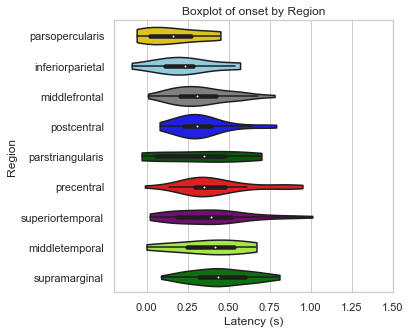

Median values:
region
inferiorparietal    0.235
middlefrontal       0.310
middletemporal      0.420
parsopercularis     0.160
parstriangularis    0.350
postcentral         0.310
precentral          0.350
superiortemporal    0.390
supramarginal       0.435
Name: onset, dtype: float64

Quantiles:
region                
inferiorparietal  0.25    0.1150
                  0.50    0.2350
                  0.75    0.2850
middlefrontal     0.25    0.2050
                  0.50    0.3100
                  0.75    0.4250
middletemporal    0.25    0.2450
                  0.50    0.4200
                  0.75    0.5300
parsopercularis   0.25    0.0200
                  0.50    0.1600
                  0.75    0.2700
parstriangularis  0.25    0.0600
                  0.50    0.3500
                  0.75    0.4800
postcentral       0.25    0.2300
                  0.50    0.3100
                  0.75    0.3950
precentral        0.25    0.2975
                  0.50    0.3500
                  0.7

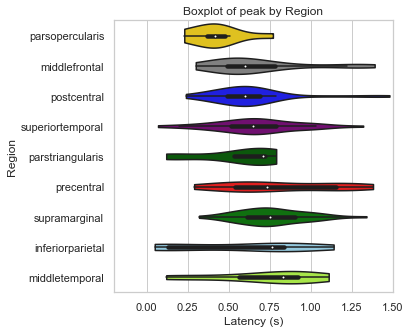

Median values:
region
inferiorparietal    0.765
middlefrontal       0.600
middletemporal      0.830
parsopercularis     0.420
parstriangularis    0.710
postcentral         0.600
precentral          0.735
superiortemporal    0.650
supramarginal       0.750
Name: peak, dtype: float64

Quantiles:
region                
inferiorparietal  0.25    0.1325
                  0.50    0.7650
                  0.75    0.8375
middlefrontal     0.25    0.4900
                  0.50    0.6000
                  0.75    0.7850
middletemporal    0.25    0.5650
                  0.50    0.8300
                  0.75    0.9250
parsopercularis   0.25    0.3700
                  0.50    0.4200
                  0.75    0.4800
parstriangularis  0.25    0.5300
                  0.50    0.7100
                  0.75    0.7200
postcentral       0.25    0.4900
                  0.50    0.6000
                  0.75    0.6900
precentral        0.25    0.5375
                  0.50    0.7350
                  0.75

In [101]:
test_list = ['covert']
time_list = ['onset','peak']

for time_point in time_list:
    plot_region(test_list, time_point)

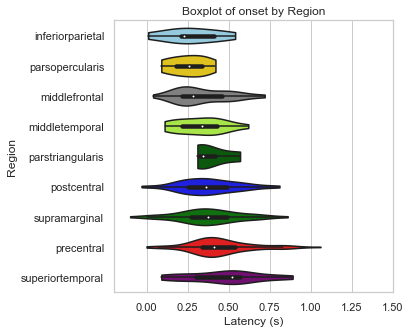

Median values:
region
inferiorparietal    0.230
middlefrontal       0.285
middletemporal      0.340
parsopercularis     0.260
parstriangularis    0.345
postcentral         0.360
precentral          0.410
superiortemporal    0.520
supramarginal       0.375
Name: onset, dtype: float64

Quantiles:
region                
inferiorparietal  0.25    0.2100
                  0.50    0.2300
                  0.75    0.4100
middlefrontal     0.25    0.2150
                  0.50    0.2850
                  0.75    0.4575
middletemporal    0.25    0.2150
                  0.50    0.3400
                  0.75    0.4300
parsopercularis   0.25    0.1800
                  0.50    0.2600
                  0.75    0.3350
parstriangularis  0.25    0.3175
                  0.50    0.3450
                  0.75    0.4200
postcentral       0.25    0.2500
                  0.50    0.3600
                  0.75    0.4875
precentral        0.25    0.3400
                  0.50    0.4100
                  0.7

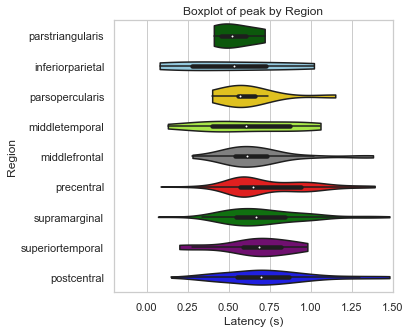

Median values:
region
inferiorparietal    0.530
middlefrontal       0.615
middletemporal      0.605
parsopercularis     0.570
parstriangularis    0.520
postcentral         0.700
precentral          0.650
superiortemporal    0.685
supramarginal       0.670
Name: peak, dtype: float64

Quantiles:
region                
inferiorparietal  0.25    0.2800
                  0.50    0.5300
                  0.75    0.7300
middlefrontal     0.25    0.5400
                  0.50    0.6150
                  0.75    0.7350
middletemporal    0.25    0.3975
                  0.50    0.6050
                  0.75    0.8750
parsopercularis   0.25    0.5550
                  0.50    0.5700
                  0.75    0.6600
parstriangularis  0.25    0.4550
                  0.50    0.5200
                  0.75    0.6075
postcentral       0.25    0.5525
                  0.50    0.7000
                  0.75    0.8700
precentral        0.25    0.5700
                  0.50    0.6500
                  0.75

In [99]:
test_list = ['C-O covert']
time_list = ['onset','peak']

for time_point in time_list:
    plot_region(test_list, time_point)

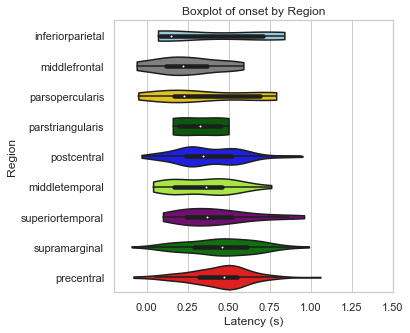

Median values:
region
inferiorparietal    0.150
middlefrontal       0.225
middletemporal      0.360
parsopercularis     0.230
parstriangularis    0.325
postcentral         0.345
precentral          0.470
superiortemporal    0.370
supramarginal       0.460
Name: onset, dtype: float64

Quantiles:
region                
inferiorparietal  0.25    0.0800
                  0.50    0.1500
                  0.75    0.7100
middlefrontal     0.25    0.1200
                  0.50    0.2250
                  0.75    0.3675
middletemporal    0.25    0.1675
                  0.50    0.3600
                  0.75    0.4600
parsopercularis   0.25    0.1700
                  0.50    0.2300
                  0.75    0.6900
parstriangularis  0.25    0.1975
                  0.50    0.3250
                  0.75    0.4550
postcentral       0.25    0.2400
                  0.50    0.3450
                  0.75    0.5200
precentral        0.25    0.3200
                  0.50    0.4700
                  0.7

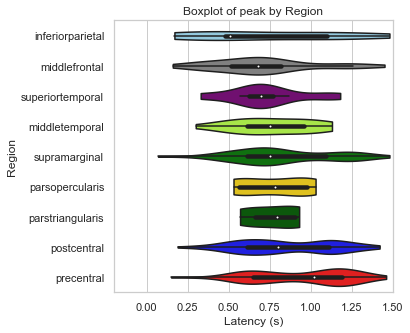

Median values:
region
inferiorparietal    0.510
middlefrontal       0.680
middletemporal      0.750
parsopercularis     0.780
parstriangularis    0.795
postcentral         0.800
precentral          1.020
superiortemporal    0.695
supramarginal       0.755
Name: peak, dtype: float64

Quantiles:
region                
inferiorparietal  0.25    0.4800
                  0.50    0.5100
                  0.75    1.1000
middlefrontal     0.25    0.5150
                  0.50    0.6800
                  0.75    0.8200
middletemporal    0.25    0.6150
                  0.50    0.7500
                  0.75    0.9600
parsopercularis   0.25    0.5650
                  0.50    0.7800
                  0.75    0.9800
parstriangularis  0.25    0.6600
                  0.50    0.7950
                  0.75    0.9075
postcentral       0.25    0.6100
                  0.50    0.8000
                  0.75    1.1100
precentral        0.25    0.6500
                  0.50    1.0200
                  0.75

In [102]:
test_list = ['C-O overt']
time_list = ['onset','peak']

for time_point in time_list:
    plot_region(test_list, time_point)

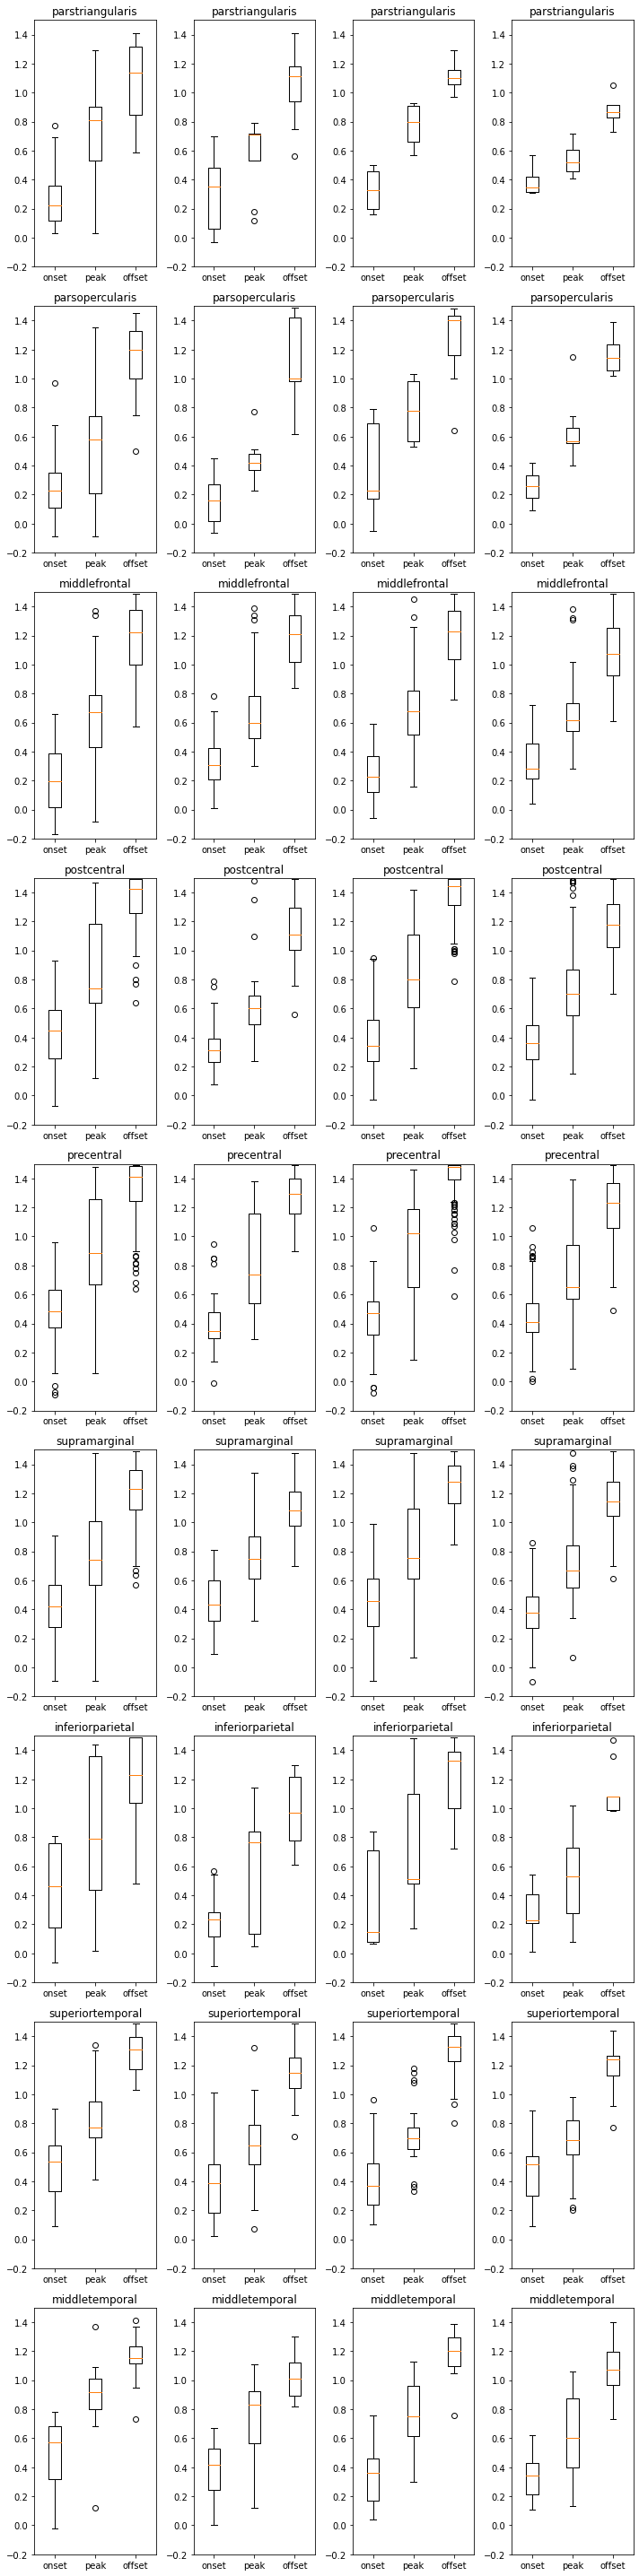

In [204]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 40))

gs = gridspec.GridSpec(len(watch_region_list),4)



for i in range(len(watch_region_list)):
    for j in range(4):
        ax = plt.subplot(gs[i,j])
        if j==0:
            ax.boxplot((pd.DataFrame(set_A[watch_region_list[i]]).values-150)/100, labels=['onset','peak','offset'])
        if j==1:
            ax.boxplot((pd.DataFrame(set_B[watch_region_list[i]]).values-150)/100, labels=['onset','peak','offset'])
        if j==2:
            ax.boxplot((pd.DataFrame(set_AB[watch_region_list[i]]).values-150)/100,labels=['onset','peak','offset'])
        if j==3:
            ax.boxplot((pd.DataFrame(set_BA[watch_region_list[i]]).values-150)/100, labels=['onset','peak','offset'])
        plt.ylim([-0.2,1.5])
        plt.title(watch_region_list[i])
        plt.tight_layout()

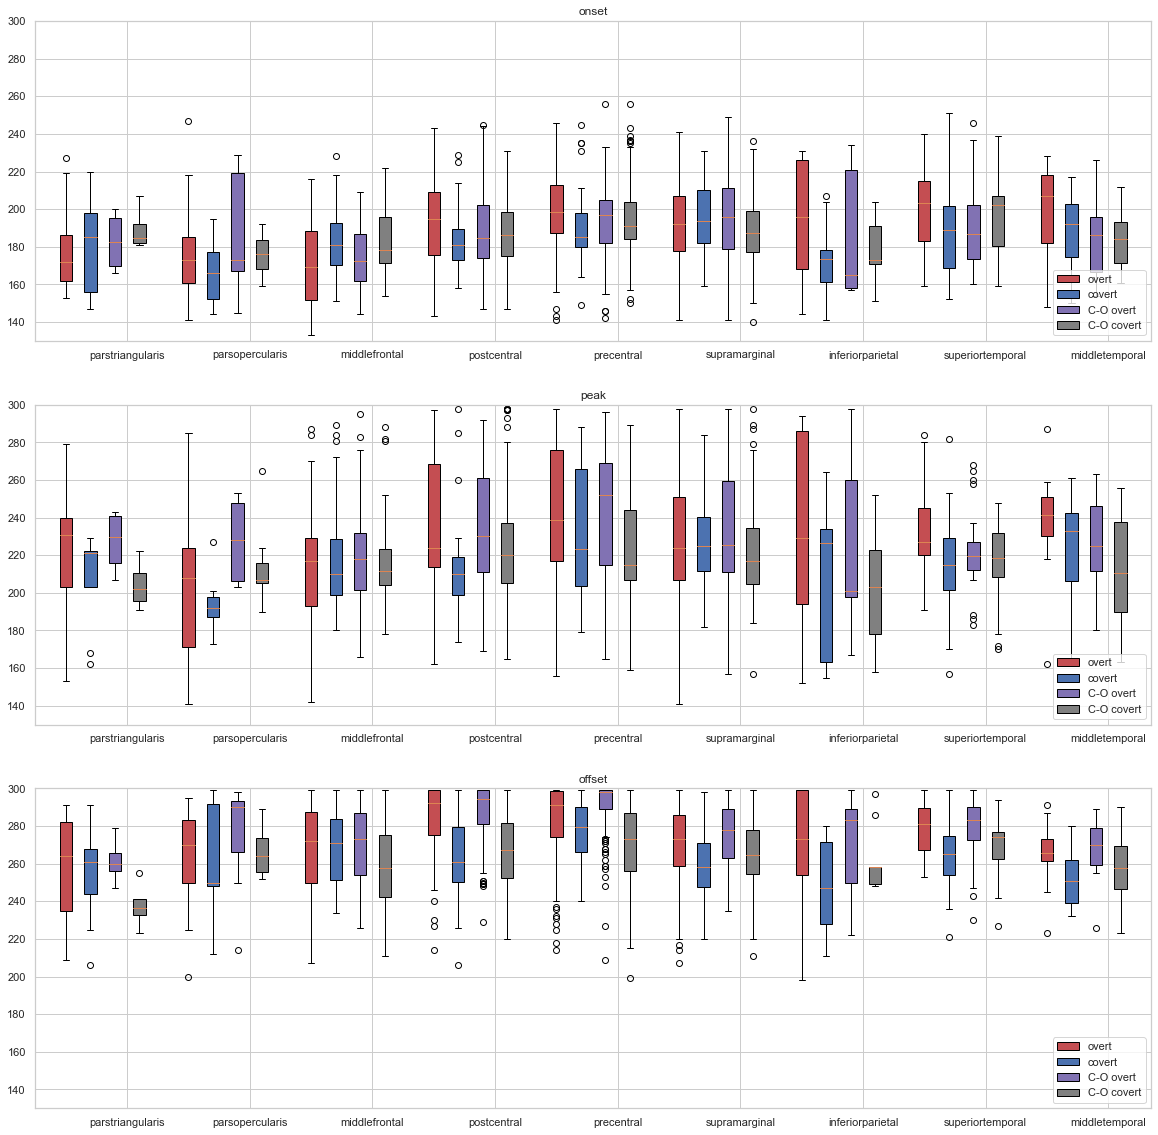

In [132]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 20))

gs = gridspec.GridSpec(3,1)

data_name_list = ['onset','peak','offset']
labels = ['overt','covert','C-O overt','C-O covert']
colors = ['r','b','m','grey']
for data_i in range(len(data_name_list)): 
    data = {}
    ax = plt.subplot(gs[data_i])
    width_space = 2
    x_position = []
    
    for i in range(len(watch_region_list)):

        data[watch_region_list[i]] = []
        
        data[watch_region_list[i]].append(set_A[watch_region_list[i]][data_name_list[data_i]])
        data[watch_region_list[i]].append(set_B[watch_region_list[i]][data_name_list[data_i]])
        data[watch_region_list[i]].append(set_AB[watch_region_list[i]][data_name_list[data_i]])
        data[watch_region_list[i]].append(set_BA[watch_region_list[i]][data_name_list[data_i]])
        bplot = plt.boxplot(data[watch_region_list[i]], patch_artist=True,labels=labels,positions=(1+i*width_space,1.4+i*width_space,1.8+i*width_space,2.2+i*width_space),widths=0.2) 

        x_position.append(1+i*width_space)
        #将4个箱分别上色
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
        
    plt.xticks([i + width_space/ 2 for i in x_position], watch_region_list)
    plt.legend(bplot['boxes'],labels,loc='lower right')
    plt.ylim([130,300])
    plt.title(data_name_list[data_i])

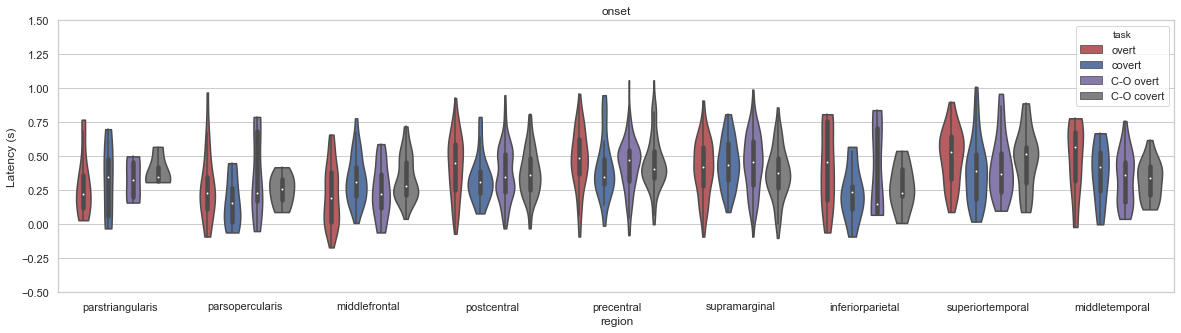

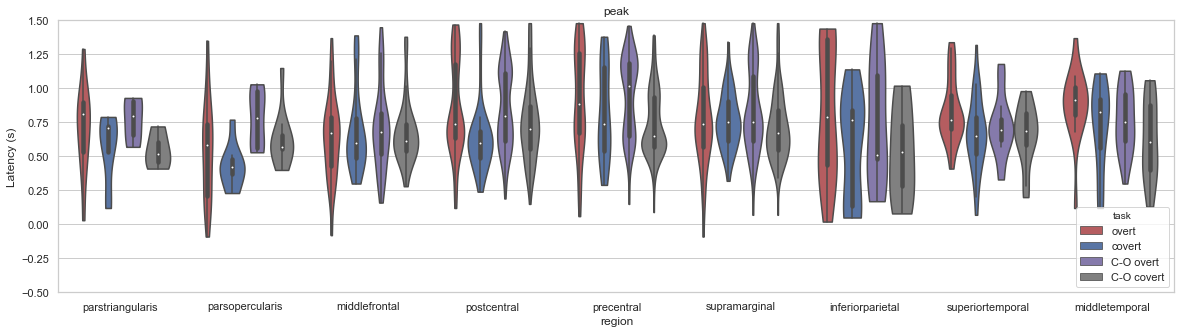

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ['r','b','m','grey']
data_name_list = ['onset','peak']

for time_point in data_name_list:
    # 绘制小提琴图
    plt.figure(figsize=(20, 5))  # 可选，设置图形大小
    sns.violinplot(x='region', y=time_point, hue='task', data=df, palette=colors,cut=0)

    # 添加标题和标签（可选）
    plt.title(time_point)
    # plt.xlabel('Region')
    plt.ylabel('Latency (s)')
    plt.ylim([-0.5,1.5])

    # 显示图形
    plt.show()


In [105]:
HS_list = [44, 45, 47, 48, 50,54, 71,73,76,78]
clear_path="/Users/zhaozehao/Desktop/reading task/"
test = classification(HS_list,clear_path)
print(test)

{'44': {'postcentral': [0, 1, 2, 3, 4, 5, 6, 7, 16, 17, 18, 19, 20, 21, 22, 32, 33, 34, 35, 49, 50, 71, 72, 73, 74, 75, 76, 86, 87, 88, 89, 90, 91, 92, 102, 103, 104, 105, 106, 107, 119, 120], 'precentral': [8, 9, 10, 11, 23, 24, 25, 36, 37, 38, 39, 40, 51, 52, 53, 54, 55, 56, 77, 78, 79, 95, 108, 121, 122, 123], 'middlefrontal': [12, 13, 14, 15, 26, 27, 28, 29, 30, 31, 41, 42, 43, 44, 45, 46, 47, 57, 58, 59, 60, 61, 62, 63, 93, 94, 109, 110, 111, 124, 125, 126, 127], 'superiortemporal': [48, 112], 'supramarginal': [64, 65, 66, 67, 68, 69, 70, 80, 81, 82, 83, 84, 85, 96, 97, 98, 99, 100, 101, 113, 114, 115, 116, 117, 118]}, '45': {'supramarginal': [0, 1, 2, 3, 4, 5, 16, 17, 18, 19, 20, 21, 34, 64, 65, 66, 67, 68, 69, 70, 80, 81, 82, 83, 84, 85, 86, 87, 96, 97, 98, 99, 100, 101, 102, 103, 112, 113, 114, 115, 116, 117, 118], 'postcentral': [6, 7, 8, 9, 10, 11, 22, 23, 24, 25, 32, 33, 35, 36, 37, 38, 39, 40, 48, 49, 50, 51, 52, 53, 71, 72, 73, 74, 75, 76, 77, 78, 79, 88, 89, 90, 91, 92, 9

In [107]:
HS_list = [44, 45, 47, 48, 50, 54, 71, 73, 76, 78]

# 初始化一个空列表，用于存放所有的keys
all_keys = []

# 遍历HS_list
for HS in HS_list:
    # 获取对应的test[str(HS)]字典的keys，并加入all_keys列表中
    all_keys.extend(test[str(HS)].keys())

# 使用set去除重复值，再转换回列表
unique_keys = list(set(all_keys))

# 输出结果
print(unique_keys)

['superiorfrontal', 'postcentral', 'parsorbitalis', 'inferiortemporal', 'parsopercularis', 'inferiorparietal', 'superiortemporal', 'middletemporal', 'lateraloccipital', 'supramarginal', 'parstriangularis', 'superiorparietal', 'middlefrontal', 'precentral']


In [108]:
all_region_list = ['parsorbitalis','parstriangularis', 'parsopercularis', 'middlefrontal','superiorfrontal',
 'postcentral','precentral',
 'supramarginal', 'inferiorparietal','superiorparietal',
 'superiortemporal', 'middletemporal','inferiortemporal',  
 'lateraloccipital']
len(all_region_list)

14

In [109]:
watch_region_list

['parstriangularis',
 'parsopercularis',
 'middlefrontal',
 'postcentral',
 'precentral',
 'supramarginal',
 'inferiorparietal',
 'superiortemporal',
 'middletemporal']

In [110]:
# 假设你已经有了 test 字典、HS_list 和 watch_region_list

# 初始化 region_amount_list
region_amount_list = {}

# 遍历 HS_list 和 watch_region_list
for HS in HS_list:
    for region in watch_region_list:
        # 检查 test[HS] 中是否包含 region
        if region in test[str(HS)].keys():
            # 获取当前 HS 和 region 对应的列表
            current_list = test[str(HS)][region]

            # 计算列表长度
            length = len(current_list)

            # 将长度添加到 region_amount_list 中
            if region in region_amount_list:
                region_amount_list[region] += length
            else:
                region_amount_list[region] = length


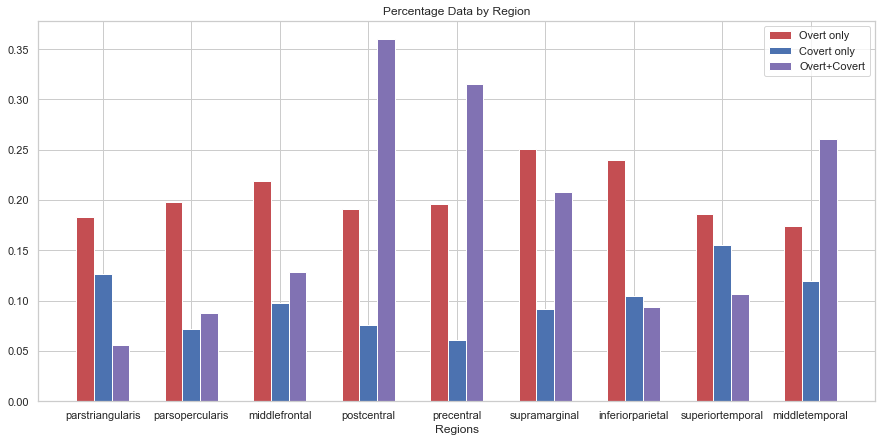

In [136]:
labels = ['overt','covert','C-O overt','C-O covert']
colors = ['r','b','m','g']
new_labels = ["Overt only","Covert only","Overt+Covert"]

percentage = {}
width_space = 2
x_position = []

for i in range(len(watch_region_list)):

    percentage[watch_region_list[i]] = []

    percentage[watch_region_list[i]].append(len(data[watch_region_list[i]][0])/region_amount_list[watch_region_list[i]])
    percentage[watch_region_list[i]].append(len(data[watch_region_list[i]][1])/region_amount_list[watch_region_list[i]])
    percentage[watch_region_list[i]].append(len(data[watch_region_list[i]][2])/region_amount_list[watch_region_list[i]])

# 提取所有的 region 和相应的数据
regions = list(percentage.keys())
ratio = np.array([percentage[region] for region in regions])

# 设置条形图的位置
x = np.arange(len(regions))

# 绘制条形图
width = 0.2  # 条的宽度
colors = ['r','b','m']  # 每个条的颜色

fig, ax = plt.subplots(figsize=(15, 7))
for i in range(3):
    ax.bar(x + i*width, ratio[:, i], width, label=new_labels[i], color=colors[i])

# 设置 x 轴标签和标题
ax.set_xlabel('Regions')
ax.set_title('Percentage Data by Region')

# 设置 x 轴刻度位置和标签
ax.set_xticks(x + width)
ax.set_xticklabels(regions)

# 添加图例
ax.legend()

# 显示图形
plt.show()


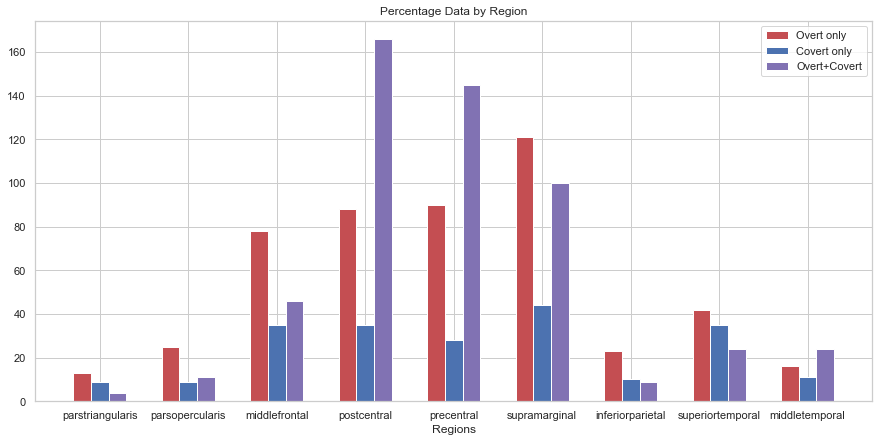

In [135]:
labels = ['overt','covert','C-O overt','C-O covert']
colors = ['r','b','m','g']
new_labels = ["Overt only","Covert only","Overt+Covert"]

percentage = {}
width_space = 2
x_position = []

for i in range(len(watch_region_list)):

    percentage[watch_region_list[i]] = []

    percentage[watch_region_list[i]].append(len(data[watch_region_list[i]][0]))
    percentage[watch_region_list[i]].append(len(data[watch_region_list[i]][1]))
    percentage[watch_region_list[i]].append(len(data[watch_region_list[i]][2]))

# 提取所有的 region 和相应的数据
regions = list(percentage.keys())
ratio = np.array([percentage[region] for region in regions])

# 设置条形图的位置
x = np.arange(len(regions))

# 绘制条形图
width = 0.2  # 条的宽度
colors = ['r','b','m']  # 每个条的颜色

fig, ax = plt.subplots(figsize=(15, 7))
for i in range(3):
    ax.bar(x + i*width, ratio[:, i], width, label=new_labels[i], color=colors[i])

# 设置 x 轴标签和标题
ax.set_xlabel('Regions')
ax.set_title('Percentage Data by Region')

# 设置 x 轴刻度位置和标签
ax.set_xticks(x + width)
ax.set_xticklabels(regions)

# 添加图例
ax.legend()

# 显示图形
plt.show()


# 画图，根据子图内电极数目调整每个子图宽度

In [115]:
import matplotlib.gridspec as gridspec

remove_region = {}
remove_list = ['lateraloccipital', 'inferiortemporal','bankssts','superiorfrontal', 'parsorbitalis','rostralmiddlefrontal']
remove_region={'overt':remove_list,'covert':remove_list,'cue':remove_list}
#把各个任务空的脑区去除
for task in task_list:
    for region in place_list:
        if (len(avgECoG[task][region]))< 5:
            remove_region[task].append(region)
    print(remove_region[task])

['lateraloccipital', 'inferiortemporal', 'bankssts', 'superiorfrontal', 'parsorbitalis', 'rostralmiddlefrontal', 'inferiortemporal', 'parsorbitalis', 'superiorfrontal']
['lateraloccipital', 'inferiortemporal', 'bankssts', 'superiorfrontal', 'parsorbitalis', 'rostralmiddlefrontal', 'inferiortemporal', 'parsorbitalis', 'superiorfrontal', 'parsorbitalis', 'superiorfrontal']
['lateraloccipital', 'inferiortemporal', 'bankssts', 'superiorfrontal', 'parsorbitalis', 'rostralmiddlefrontal', 'inferiortemporal', 'parsorbitalis', 'superiorfrontal', 'parsorbitalis', 'superiorfrontal', 'inferiorparietal', 'inferiortemporal', 'lateraloccipital', 'parsorbitalis', 'superiorfrontal', 'superiorparietal']


overt


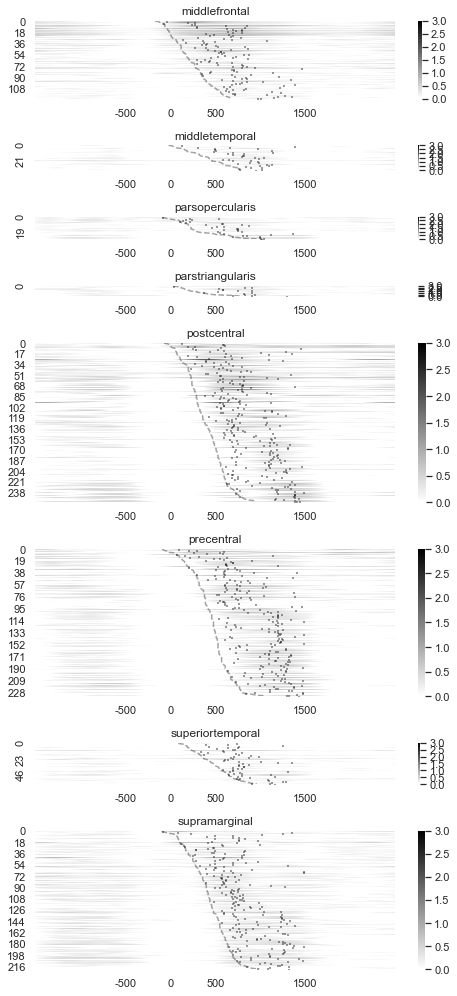

covert


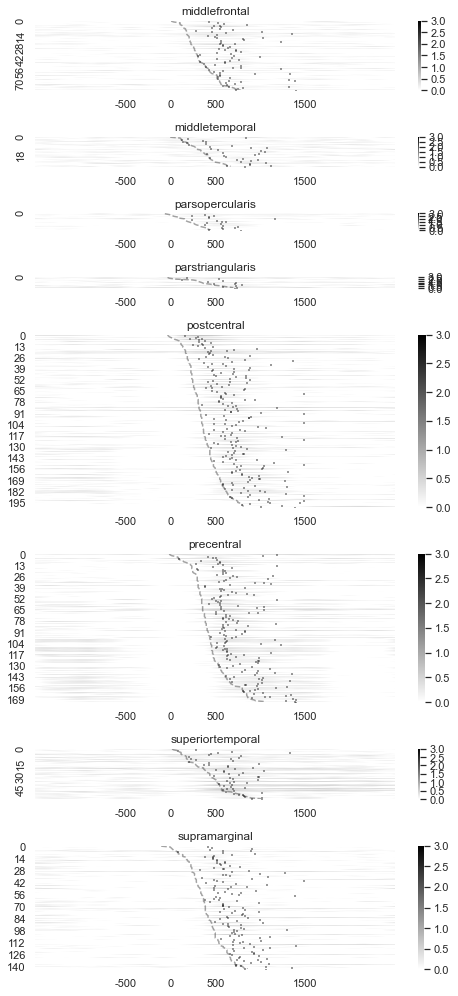

cue


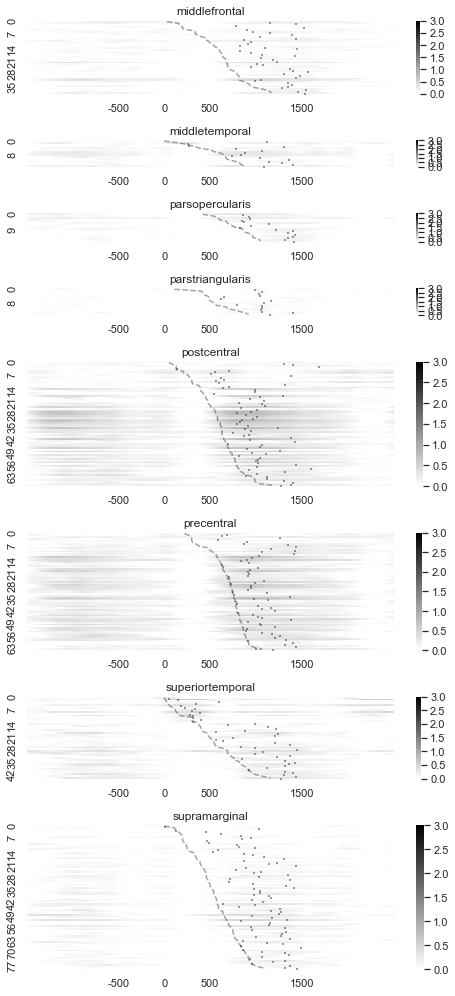

In [140]:

task_dict = {}
for task in ["overt","covert","cue"]:
    data_counts = []
    filtered_place_list = [ i for i in place_list if i not in remove_region[task]]
#     print(filtered_place_list)
    start_time = 150 if task == "cue" else 130
    end_time = start_time+120
    blank_list = []
    onset = onset_time_dict[task]
    offset = end_time_dict[task]
    peak = {}
    for i in range(len(filtered_place_list)):
        temp = elec_avg_ECoG[task][filtered_place_list[i]]
        
        if len(temp) == 0:
            blank_list.append(i)
            continue
        data_counts.append(len(temp))
        # temp[temp<0]=0
        peak[filtered_place_list[i]] = np.zeros(len(temp)).astype(np.float64)
        for j in range(len(temp)):
            peak[filtered_place_list[i]][j] = int(np.argmax(temp[j][int(onset[filtered_place_list[i]][j]):int(offset[filtered_place_list[i]][j])])+onset[filtered_place_list[i]][j])
            
    total_counts = sum(data_counts)
    height_ratios = [count / total_counts for count in data_counts]
    
#     fig = plt.figure(figsize=(15, 15))
    fig = plt.figure(figsize=(7, 14))

    gs = gridspec.GridSpec(len(data_counts),1, height_ratios=height_ratios)

#     fig.suptitle(task, fontsize=16)
    print(task)
    blank_num = 0
    for place_ind in range(len(filtered_place_list)):

        #转换数据方便调用
        elec_avg_ECoG[task][filtered_place_list[place_ind]] = np.array(elec_avg_ECoG[task][filtered_place_list[place_ind]])
        onset[filtered_place_list[place_ind]] = np.array(onset[filtered_place_list[place_ind]])
        peak[filtered_place_list[place_ind]] = np.array(peak[filtered_place_list[place_ind]])
        #按照onset或者peak顺序重新排列
        temp = elec_avg_ECoG[task][filtered_place_list[place_ind]][onset[filtered_place_list[place_ind]].argsort()]
        # temp[temp<0]=0
        ax = plt.subplot(gs[place_ind])
        
        ax.set_title(filtered_place_list[place_ind])
        sns.heatmap(temp, cmap="binary", ax=ax, vmax=3, vmin=0)
        xonsetplot = onset[filtered_place_list[place_ind]][onset[filtered_place_list[place_ind]].argsort()]
        xpeakplot = peak[filtered_place_list[place_ind]][onset[filtered_place_list[place_ind]].argsort()]
    
        yforplot = np.arange(1, len(onset[filtered_place_list[place_ind]]) + 1) - 0.5
    
        ax.scatter(xpeakplot, yforplot, c="k", alpha=0.4, s=1,marker='s')
        #ax.plot(xpeakplot, yforplot, "b--", alpha=0.4)
        ax.plot(xonsetplot, yforplot, "k--", alpha=0.4)
        plt.xticks([100,150,200,300],[-500,0,500,1500],rotation = 0)

#     plt.xticks([100,150,200,300],[100,150,200,300])
    plt.tight_layout()
    plt.show()





In [219]:
len(elec_avg_ECoG[task][filtered_place_list[place_ind]])

81